SINGLE-CELL TECHNOLOGY COMPARISON ANALYSIS
ChronoSeq vs 10X Genomics

Step 1: Loading and combining 10X Genomics replicates...
Loading 10X replicate 1...
Looking for files in: ./GSM5687481_k562_rep1/
Loading 10X replicate 2...
Looking for files in: ./GSM5687482_k562_rep2/
Combining 10X replicates...
Calculating 10X QC metrics...
Found 13 mitochondrial genes with prefix 'MT-'
Found 103 ribosomal genes with prefixes 'RPS' and 'RPL'
Combined 10X dataset shape: (5141, 36601)
Rep1 cells: 2543
Rep2 cells: 2598
Mitochondrial genes found: 13
Ribosomal genes found: 103

Step 2: Loading ChronoSeq data...
Loading ChronoSeq data...
Looking for file: scK562_NegCTRL_2X_Cells.csv.gz
ChronoSeq data shape: (9357, 17309) (cells x genes)
First few cell barcodes: ['GTTCGCCTTCCC', 'CGTGTCCCTGCA', 'TACGCCACGTAT']
First few genes: ['A1BG', 'A1BG-AS1', 'AAAS']
Calculating ChronoSeq QC metrics...
Found 20 mitochondrial genes with prefix 'MT-'
Found 334 ribosomal genes with prefixes 'RPS' and 'RPL'
ChronoSeq An

... storing 'replicate' as categorical
... storing 'technology' as categorical
... storing 'feature_types-10X' as categorical



Step 4: Creating publication-quality comparison plots...
Creating violin plots...


Creating box plots with statistics...


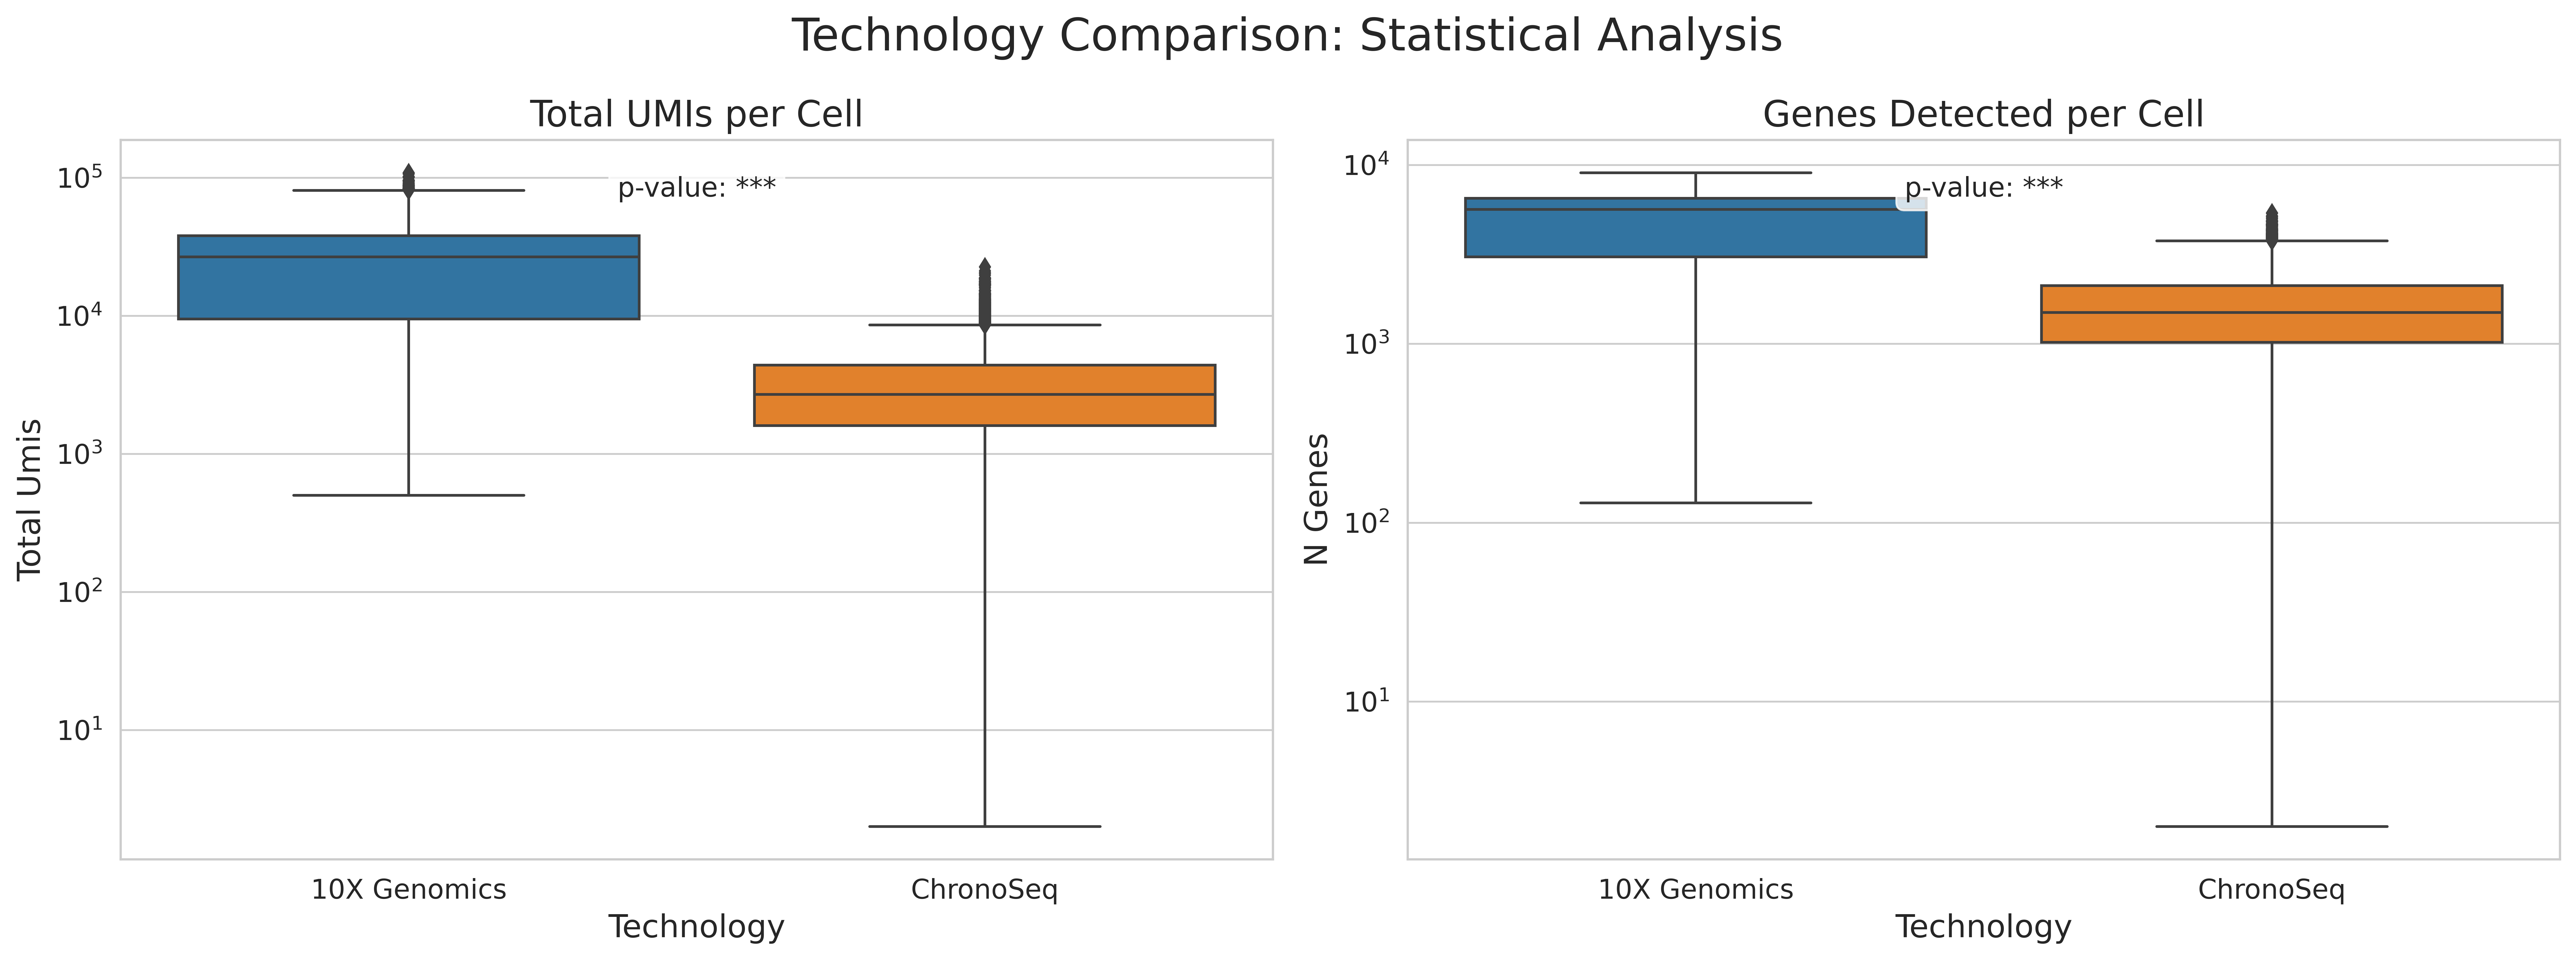

Creating scatter plots...


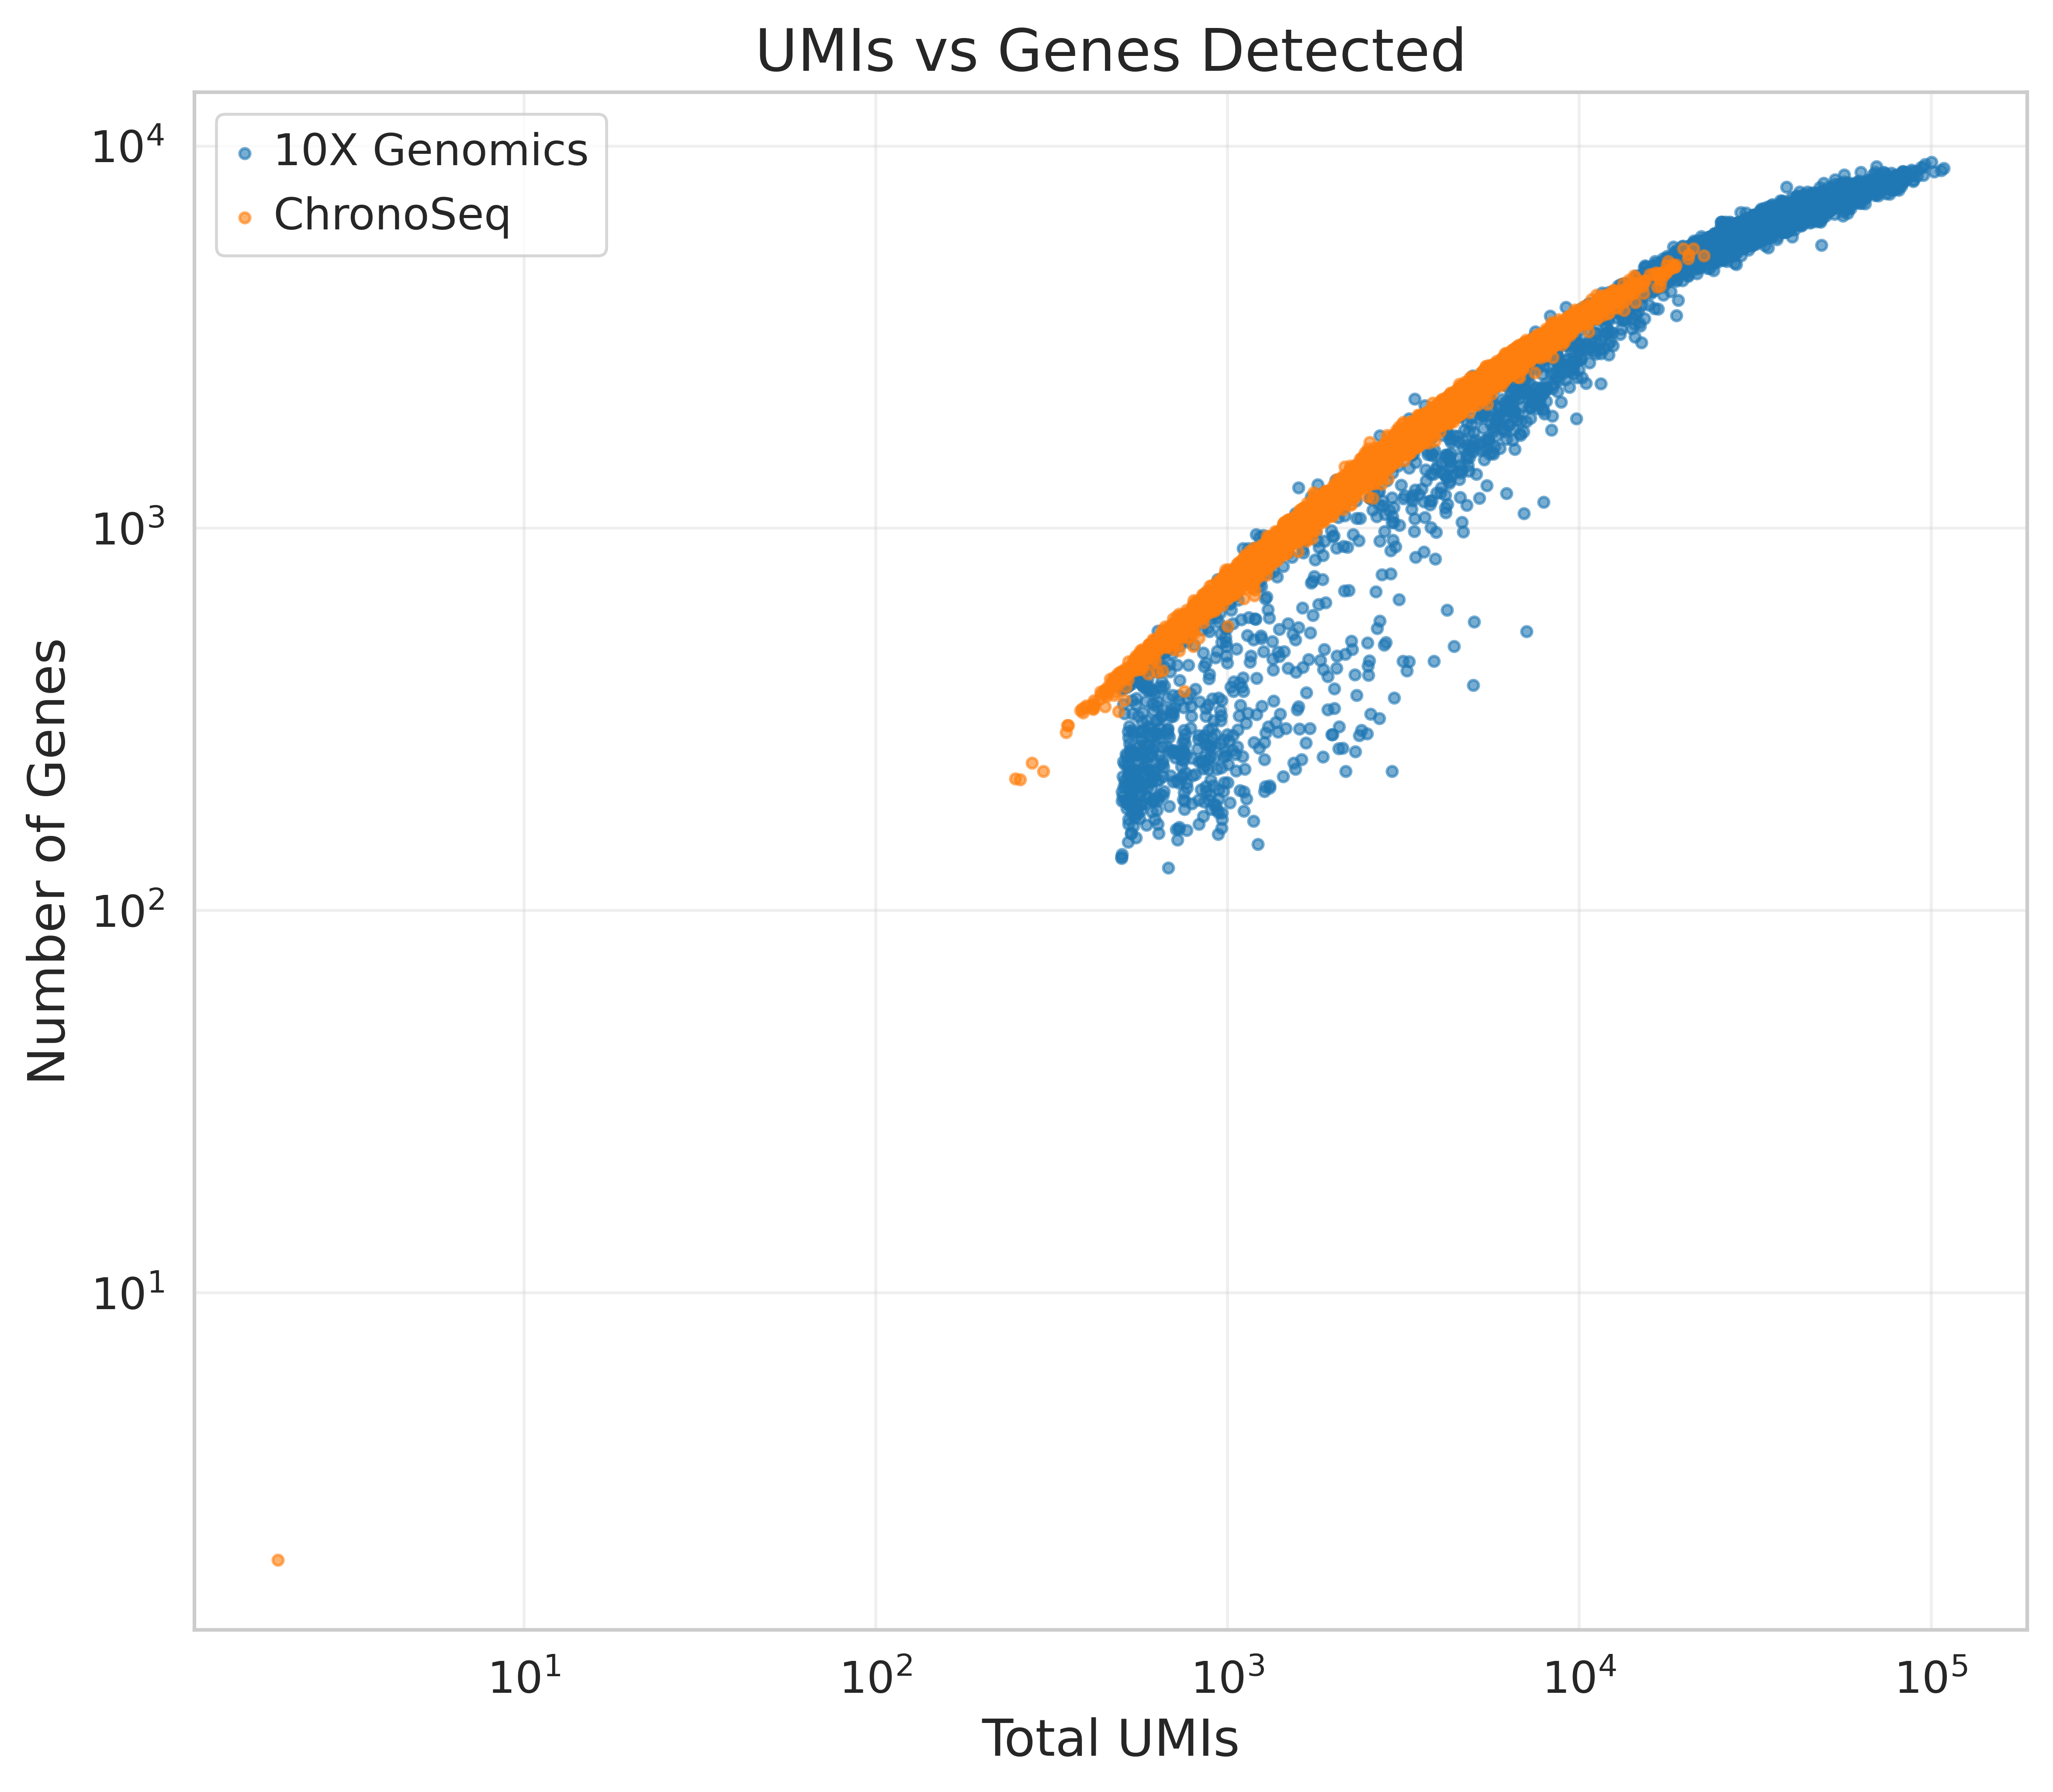

Creating performance comparison plot...



Step 5: Generating summary statistics...

TECHNOLOGY COMPARISON SUMMARY STATISTICS
                total_umis                           n_genes                  \
                      mean   median       std count     mean median      std   
technology                                                                     
10X Genomics  26606.939453  26716.0  18936.54  5141  4788.33   5651  2392.68   
ChronoSeq      3376.219971   2693.0   2474.98  9357  1641.33   1495   794.53   

                    
             count  
technology          
10X Genomics  5141  
ChronoSeq     9357  

STATISTICAL TESTS (Mann-Whitney U)
Total Umis:
  Statistic: 40464477.50
  P-value: 0.00e+00
  Significant: Yes

N Genes:
  Statistic: 39351655.50
  P-value: 0.00e+00
  Significant: Yes


ANALYSIS COMPLETE!
Generated high-resolution SVG files:
- technology_comparison_violin.svg
- technology_comparison_boxplots.svg
- technology_comparison_scatter.svg
- technology_performance_comparison.svg


In [1]:
# Single-Cell Technology Comparison: ChronoSeq vs 10X Genomics
# Complete self-contained Jupyter notebook cell

import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

# Set matplotlib to use SVG backend for high resolution
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.format'] = 'svg'
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text remains as text in SVG

def load_and_combine_10x_replicates(rep1_path, rep2_path):
    """Load and combine two 10X Genomics replicates."""
    # Set scanpy settings for high-quality plots
    sc.settings.set_figure_params(dpi=300, facecolor='white', figsize=(12, 8), format='svg')
    
    print("Loading 10X replicate 1...")
    print(f"Looking for files in: {rep1_path}")
    adata1 = sc.read_10x_mtx(rep1_path, var_names='gene_symbols', cache=True)
    adata1.var_names_make_unique()
    
    print("Loading 10X replicate 2...")
    print(f"Looking for files in: {rep2_path}")
    adata2 = sc.read_10x_mtx(rep2_path, var_names='gene_symbols', cache=True)
    adata2.var_names_make_unique()
    
    # Make matrices dense if sparse
    adata1.X = adata1.X.toarray() if hasattr(adata1.X, 'toarray') else adata1.X
    adata2.X = adata2.X.toarray() if hasattr(adata2.X, 'toarray') else adata2.X
    
    print("Combining 10X replicates...")
    combined_adata = adata1.concatenate(adata2, batch_key='replicate', batch_categories=['Rep1', 'Rep2'])
    
    print("Calculating 10X QC metrics...")
    # Mitochondrial genes - try different common prefixes
    mt_gene_prefixes = ['MT-', 'mt-', 'Mt-', 'MT_', 'mt_']
    combined_adata.var['mt'] = False
    for prefix in mt_gene_prefixes:
        mt_mask = combined_adata.var_names.str.startswith(prefix)
        if mt_mask.any():
            combined_adata.var['mt'] = combined_adata.var['mt'] | mt_mask
            print(f"Found {mt_mask.sum()} mitochondrial genes with prefix '{prefix}'")
            break
    
    if not combined_adata.var['mt'].any():
        print("Warning: No mitochondrial genes found with standard prefixes")
    
    # Ribosomal genes - try different common prefixes
    ribo_prefixes = [('RPS', 'RPL'), ('rps', 'rpl'), ('Rps', 'Rpl'), ('RPS_', 'RPL_')]
    combined_adata.var['ribo'] = False
    for rps_prefix, rpl_prefix in ribo_prefixes:
        ribo_mask = (combined_adata.var_names.str.startswith(rps_prefix) | 
                     combined_adata.var_names.str.startswith(rpl_prefix))
        if ribo_mask.any():
            combined_adata.var['ribo'] = combined_adata.var['ribo'] | ribo_mask
            print(f"Found {ribo_mask.sum()} ribosomal genes with prefixes '{rps_prefix}' and '{rpl_prefix}'")
            break
    
    if not combined_adata.var['ribo'].any():
        print("Warning: No ribosomal genes found with standard prefixes")
    
    # Calculate per-cell QC metrics
    sc.pp.calculate_qc_metrics(combined_adata, percent_top=None, log1p=False, inplace=True)
    
    # Add custom metric names with error handling
    combined_adata.obs['n_genes'] = combined_adata.obs['n_genes_by_counts']
    combined_adata.obs['total_umis'] = combined_adata.obs['total_counts']
    
    # Handle mitochondrial percentage with fallback
    if 'pct_counts_mt' in combined_adata.obs.columns:
        combined_adata.obs['percent_mt'] = combined_adata.obs['pct_counts_mt']
    else:
        print("Warning: Mitochondrial percentage not calculated, setting to 0")
        combined_adata.obs['percent_mt'] = 0.0
    
    # Handle ribosomal percentage with fallback
    if 'pct_counts_ribo' in combined_adata.obs.columns:
        combined_adata.obs['percent_ribo'] = combined_adata.obs['pct_counts_ribo']
    else:
        print("Warning: Ribosomal percentage not calculated, setting to 0")
        combined_adata.obs['percent_ribo'] = 0.0
    
    combined_adata.obs['technology'] = '10X Genomics'
    
    print(f"Combined 10X dataset shape: {combined_adata.shape}")
    print(f"Rep1 cells: {sum(combined_adata.obs['replicate'] == 'Rep1')}")
    print(f"Rep2 cells: {sum(combined_adata.obs['replicate'] == 'Rep2')}")
    print(f"Mitochondrial genes found: {combined_adata.var['mt'].sum()}")
    print(f"Ribosomal genes found: {combined_adata.var['ribo'].sum()}")
    
    return combined_adata

def load_chronoseq_data(csv_file_path):
    """Load ChronoSeq data from CSV file where genes are columns and cell barcodes are rows."""
    print("Loading ChronoSeq data...")
    print(f"Looking for file: {csv_file_path}")
    
    df = pd.read_csv(csv_file_path, sep=",")
    countMat=df.iloc[:,1:-2]
    countMat.index=df["CELL BARCODES"].to_list()
    df=countMat
    
    print(f"ChronoSeq data shape: {df.shape} (cells x genes)")
    print(f"First few cell barcodes: {df.index[:3].tolist()}")
    print(f"First few genes: {df.columns[:3].tolist()}")
    
    adata = sc.AnnData(X=df.values)
    adata.obs_names = df.index
    adata.var_names = df.columns
    adata.var_names_make_unique()
    
    print("Calculating ChronoSeq QC metrics...")
    # Mitochondrial genes - try different common prefixes
    mt_gene_prefixes = ['MT-', 'mt-', 'Mt-', 'MT_', 'mt_']
    adata.var['mt'] = False
    for prefix in mt_gene_prefixes:
        mt_mask = adata.var_names.str.startswith(prefix)
        if mt_mask.any():
            adata.var['mt'] = adata.var['mt'] | mt_mask
            print(f"Found {mt_mask.sum()} mitochondrial genes with prefix '{prefix}'")
            break
    
    if not adata.var['mt'].any():
        print("Warning: No mitochondrial genes found with standard prefixes")
    
    # Ribosomal genes - try different common prefixes  
    ribo_prefixes = [('RPS', 'RPL'), ('rps', 'rpl'), ('Rps', 'Rpl'), ('RPS_', 'RPL_')]
    adata.var['ribo'] = False
    for rps_prefix, rpl_prefix in ribo_prefixes:
        ribo_mask = (adata.var_names.str.startswith(rps_prefix) | 
                     adata.var_names.str.startswith(rpl_prefix))
        if ribo_mask.any():
            adata.var['ribo'] = adata.var['ribo'] | ribo_mask
            print(f"Found {ribo_mask.sum()} ribosomal genes with prefixes '{rps_prefix}' and '{rpl_prefix}'")
            break
    
    if not adata.var['ribo'].any():
        print("Warning: No ribosomal genes found with standard prefixes")
    
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Add custom metric names with error handling
    adata.obs['n_genes'] = adata.obs['n_genes_by_counts']
    adata.obs['total_umis'] = adata.obs['total_counts']
    
    # Handle mitochondrial percentage with fallback
    if 'pct_counts_mt' in adata.obs.columns:
        adata.obs['percent_mt'] = adata.obs['pct_counts_mt']
    else:
        print("Warning: Mitochondrial percentage not calculated, setting to 0")
        adata.obs['percent_mt'] = 0.0
    
    # Handle ribosomal percentage with fallback
    if 'pct_counts_ribo' in adata.obs.columns:
        adata.obs['percent_ribo'] = adata.obs['pct_counts_ribo']
    else:
        print("Warning: Ribosomal percentage not calculated, setting to 0")
        adata.obs['percent_ribo'] = 0.0
    
    adata.obs['technology'] = 'ChronoSeq'
    
    print(f"ChronoSeq AnnData shape: {adata.shape}")
    print(f"Mitochondrial genes found: {adata.var['mt'].sum()}")
    print(f"Ribosomal genes found: {adata.var['ribo'].sum()}")
    
    return adata

def combine_technologies_for_comparison(tenx_adata, chronoseq_adata):
    """Combine 10X and ChronoSeq data for comparison."""
    print("Combining technologies for comparison...")
    
    common_genes = list(set(tenx_adata.var_names) & set(chronoseq_adata.var_names))
    print(f"Common genes between technologies: {len(common_genes)}")
    
    tenx_subset = tenx_adata[:, common_genes].copy()
    chronoseq_subset = chronoseq_adata[:, common_genes].copy()
    
    combined_adata = tenx_subset.concatenate(chronoseq_subset, batch_key='batch', 
                                           batch_categories=['10X', 'ChronoSeq'])
    
    tech_labels = []
    for batch in combined_adata.obs['batch']:
        tech_labels.append('10X Genomics' if batch == '10X' else 'ChronoSeq')
    
    combined_adata.obs['technology'] = tech_labels
    return combined_adata

def create_comparison_plots(combined_adata):
    """Create all comparison plots and save as high-resolution SVG files."""
    
    # Set publication-quality style
    sns.set_context('paper', font_scale=1.4)
    sns.set_style('whitegrid')
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 18,
        'savefig.dpi': 300,
        'savefig.format': 'svg',
        'svg.fonttype': 'none'
    })
    
    tech_colors = {'10X Genomics': '#1f77b4', 'ChronoSeq': '#ff7f0e'}
    
    # Plot 1: Violin plots comparison
    print("Creating violin plots...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Technology Comparison: Quality Control Metrics', fontsize=20, y=0.98)
    
    # Total UMIs
    ax1 = axes[0, 0]
    sc.pl.violin(combined_adata, keys=['total_umis'], groupby='technology', 
                 ax=ax1, show=False, stripplot=False)
    ax1.set_title('Total UMIs per Cell', fontsize=16)
    ax1.set_ylabel('UMI Counts', fontsize=14)
    ax1.set_yscale('log')
    ax1.tick_params(axis='x', rotation=0)
    
    # Genes detected
    ax2 = axes[0, 1]
    sc.pl.violin(combined_adata, keys=['n_genes'], groupby='technology', 
                 ax=ax2, show=False, stripplot=False)
    ax2.set_title('Genes Detected per Cell', fontsize=16)
    ax2.set_ylabel('Number of Genes', fontsize=14)
    ax2.set_yscale('log')
    ax2.tick_params(axis='x', rotation=0)
    
    # Mitochondrial percentage (only if we have mitochondrial genes)
    ax3 = axes[1, 0]
    if combined_adata.obs['percent_mt'].max() > 0:
        sc.pl.violin(combined_adata, keys=['percent_mt'], groupby='technology', 
                     ax=ax3, show=False, stripplot=False)
        ax3.set_title('Mitochondrial Gene Percentage', fontsize=16)
        ax3.set_ylabel('% Mitochondrial Genes', fontsize=14)
    else:
        ax3.text(0.5, 0.5, 'No Mitochondrial\nGenes Detected', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=16)
        ax3.set_title('Mitochondrial Gene Percentage', fontsize=16)
    ax3.tick_params(axis='x', rotation=0)
    
    # Ribosomal percentage (only if we have ribosomal genes)
    ax4 = axes[1, 1]
    if combined_adata.obs['percent_ribo'].max() > 0:
        sc.pl.violin(combined_adata, keys=['percent_ribo'], groupby='technology', 
                     ax=ax4, show=False, stripplot=False)
        ax4.set_title('Ribosomal Gene Percentage', fontsize=16)
        ax4.set_ylabel('% Ribosomal Genes', fontsize=14)
    else:
        ax4.text(0.5, 0.5, 'No Ribosomal\nGenes Detected', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=16)
        ax4.set_title('Ribosomal Gene Percentage', fontsize=16)
    ax4.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig('technology_comparison_violin.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Box plots with statistics
    print("Creating box plots with statistics...")
    
    # Only include metrics that have actual data
    available_metrics = ['total_umis', 'n_genes']
    available_titles = ['Total UMIs per Cell', 'Genes Detected per Cell']
    
    if combined_adata.obs['percent_mt'].max() > 0:
        available_metrics.append('percent_mt')
        available_titles.append('Mitochondrial Gene %')
        
    if combined_adata.obs['percent_ribo'].max() > 0:
        available_metrics.append('percent_ribo')
        available_titles.append('Ribosomal Gene %')
    
    # Adjust subplot layout based on available metrics
    n_metrics = len(available_metrics)
    if n_metrics <= 2:
        fig, axes = plt.subplots(1, n_metrics, figsize=(8*n_metrics, 6))
        if n_metrics == 1:
            axes = [axes]
    else:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
    
    fig.suptitle('Technology Comparison: Statistical Analysis', fontsize=20, y=0.98)
    
    for i, (metric, title) in enumerate(zip(available_metrics, available_titles)):
        ax = axes[i]
        
        sns.boxplot(data=combined_adata.obs, x='technology', y=metric, ax=ax, palette=tech_colors)
        ax.set_title(title, fontsize=16)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=14)
        ax.set_xlabel('Technology', fontsize=14)
        
        if metric in ['total_umis', 'n_genes']:
            ax.set_yscale('log')
        
        # Statistical test
        tenx_data = combined_adata.obs[combined_adata.obs['technology'] == '10X Genomics'][metric]
        chronoseq_data = combined_adata.obs[combined_adata.obs['technology'] == 'ChronoSeq'][metric]
        
        statistic, p_value = stats.mannwhitneyu(tenx_data, chronoseq_data, alternative='two-sided')
        
        if p_value < 0.001:
            significance = "***"
        elif p_value < 0.01:
            significance = "**"
        elif p_value < 0.05:
            significance = "*"
        else:
            significance = "ns"
        
        ax.text(0.5, 0.95, f'p-value: {significance}', transform=ax.transAxes, 
                ha='center', va='top', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Hide unused subplots if any
    if n_metrics < 4:
        for i in range(n_metrics, 4):
            if i < len(axes):
                axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('technology_comparison_boxplots.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 3: Scatter plots
    print("Creating scatter plots...")
    
    # Adjust scatter plots based on available data
    if combined_adata.obs['percent_mt'].max() > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # UMIs vs Genes
        ax1 = axes[0]
        for tech in ['10X Genomics', 'ChronoSeq']:
            mask = combined_adata.obs['technology'] == tech
            ax1.scatter(combined_adata.obs.loc[mask, 'total_umis'], 
                       combined_adata.obs.loc[mask, 'n_genes'],
                       alpha=0.6, s=8, color=tech_colors[tech], label=tech)
        ax1.set_xlabel('Total UMIs', fontsize=14)
        ax1.set_ylabel('Number of Genes', fontsize=14)
        ax1.set_title('UMIs vs Genes Detected', fontsize=16)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # UMIs vs Mitochondrial
        ax2 = axes[1]
        for tech in ['10X Genomics', 'ChronoSeq']:
            mask = combined_adata.obs['technology'] == tech
            ax2.scatter(combined_adata.obs.loc[mask, 'total_umis'], 
                       combined_adata.obs.loc[mask, 'percent_mt'],
                       alpha=0.6, s=8, color=tech_colors[tech], label=tech)
        ax2.set_xlabel('Total UMIs', fontsize=14)
        ax2.set_ylabel('% Mitochondrial Genes', fontsize=14)
        ax2.set_title('UMIs vs Mitochondrial Percentage', fontsize=16)
        ax2.set_xscale('log')
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
    else:
        # Only show UMIs vs Genes if no mitochondrial data
        fig, ax = plt.subplots(1, 1, figsize=(8, 7))
        
        for tech in ['10X Genomics', 'ChronoSeq']:
            mask = combined_adata.obs['technology'] == tech
            ax.scatter(combined_adata.obs.loc[mask, 'total_umis'], 
                      combined_adata.obs.loc[mask, 'n_genes'],
                      alpha=0.6, s=8, color=tech_colors[tech], label=tech)
        ax.set_xlabel('Total UMIs', fontsize=14)
        ax.set_ylabel('Number of Genes', fontsize=14)
        ax.set_title('UMIs vs Genes Detected', fontsize=16)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('technology_comparison_scatter.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 4: Performance comparison
    print("Creating performance comparison plot...")
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('ChronoSeq vs 10X Genomics: Performance Metrics', fontsize=22, y=0.98)
    
    # Cell count
    ax1 = axes[0, 0]
    tech_counts = combined_adata.obs['technology'].value_counts()
    bars = ax1.bar(tech_counts.index, tech_counts.values, 
                   color=[tech_colors[tech] for tech in tech_counts.index])
    ax1.set_title('Cells Captured', fontsize=16)
    ax1.set_ylabel('Cell Count', fontsize=14)
    ax1.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=12)
    
    # Median UMIs
    ax2 = axes[0, 1]
    median_umis = combined_adata.obs.groupby('technology')['total_umis'].median()
    bars = ax2.bar(median_umis.index, median_umis.values, 
                   color=[tech_colors[tech] for tech in median_umis.index])
    ax2.set_title('Median UMIs per Cell', fontsize=16)
    ax2.set_ylabel('UMI Count', fontsize=14)
    ax2.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=12)
    
    # Median genes
    ax3 = axes[0, 2]
    median_genes = combined_adata.obs.groupby('technology')['n_genes'].median()
    bars = ax3.bar(median_genes.index, median_genes.values, 
                   color=[tech_colors[tech] for tech in median_genes.index])
    ax3.set_title('Median Genes per Cell', fontsize=16)
    ax3.set_ylabel('Gene Count', fontsize=14)
    ax3.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=12)
    
    # Detection efficiency
    ax4 = axes[1, 0]
    combined_adata.obs['genes_per_umi'] = combined_adata.obs['n_genes'] / combined_adata.obs['total_umis']
    efficiency = combined_adata.obs.groupby('technology')['genes_per_umi'].median()
    bars = ax4.bar(efficiency.index, efficiency.values, 
                   color=[tech_colors[tech] for tech in efficiency.index])
    ax4.set_title('Detection Efficiency\n(Genes per UMI)', fontsize=16)
    ax4.set_ylabel('Genes/UMI Ratio', fontsize=14)
    ax4.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12)
    
    # Mitochondrial content (if available)
    ax5 = axes[1, 1]
    if combined_adata.obs['percent_mt'].max() > 0:
        median_mt = combined_adata.obs.groupby('technology')['percent_mt'].median()
        bars = ax5.bar(median_mt.index, median_mt.values, 
                       color=[tech_colors[tech] for tech in median_mt.index])
        ax5.set_title('Median Mitochondrial\nPercentage', fontsize=16)
        ax5.set_ylabel('% Mitochondrial', fontsize=14)
        ax5.tick_params(axis='x', rotation=45)
        
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=12)
    else:
        ax5.text(0.5, 0.5, 'No Mitochondrial\nGenes Detected', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=16)
        ax5.set_title('Median Mitochondrial\nPercentage', fontsize=16)
    
    # Dynamic range
    ax6 = axes[1, 2]
    dynamic_ranges = {}
    for tech in ['10X Genomics', 'ChronoSeq']:
        tech_data = combined_adata.obs[combined_adata.obs['technology'] == tech]['total_umis']
        dynamic_range = np.log10(tech_data.max()) - np.log10(tech_data.min())
        dynamic_ranges[tech] = dynamic_range
    
    bars = ax6.bar(dynamic_ranges.keys(), list(dynamic_ranges.values()), 
                   color=[tech_colors[tech] for tech in dynamic_ranges.keys()])
    ax6.set_title('Dynamic Range\n(Log10 UMI span)', fontsize=16)
    ax6.set_ylabel('Log10 Range', fontsize=14)
    ax6.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('technology_performance_comparison.svg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return combined_adata

def print_summary_statistics(combined_adata):
    """Print summary statistics and statistical test results."""
    print("\n" + "="*80)
    print("TECHNOLOGY COMPARISON SUMMARY STATISTICS")
    print("="*80)
    
    # Only include metrics that have meaningful data
    available_metrics = ['total_umis', 'n_genes']
    if combined_adata.obs['percent_mt'].max() > 0:
        available_metrics.append('percent_mt')
    if combined_adata.obs['percent_ribo'].max() > 0:
        available_metrics.append('percent_ribo')
    
    summary_stats = combined_adata.obs.groupby('technology')[available_metrics].agg(['mean', 'median', 'std', 'count'])
    print(summary_stats.round(2))
    
    print("\n" + "="*80)
    print("STATISTICAL TESTS (Mann-Whitney U)")
    print("="*80)
    
    for metric in available_metrics:
        tenx_data = combined_adata.obs[combined_adata.obs['technology'] == '10X Genomics'][metric]
        chronoseq_data = combined_adata.obs[combined_adata.obs['technology'] == 'ChronoSeq'][metric]
        
        statistic, p_value = stats.mannwhitneyu(tenx_data, chronoseq_data, alternative='two-sided')
        
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Statistic: {statistic:.2f}")
        print(f"  P-value: {p_value:.2e}")
        print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
        print()

# =============================================================================
# CONFIGURATION SECTION - UPDATE THESE PATHS WITH YOUR ACTUAL FILE LOCATIONS
# =============================================================================

# Update these paths to your actual file locations:
TENX_REP1_PATH = './GSM5687481_k562_rep1/'  # Directory path (not .mtx.gz file directly)
TENX_REP2_PATH = './GSM5687482_k562_rep2/'  # Directory path (not .mtx.gz file directly) 
CHRONOSEQ_CSV_PATH = 'scK562_NegCTRL_2X_Cells.csv.gz'  # Your ChronoSeq CSV file

# =============================================================================
# MAIN ANALYSIS WORKFLOW
# =============================================================================

print("="*60)
print("SINGLE-CELL TECHNOLOGY COMPARISON ANALYSIS")
print("ChronoSeq vs 10X Genomics")
print("="*60)

# Check if paths exist before proceeding
def check_paths():
    """Check if all required files exist before starting analysis."""
    errors = []
    
    # Check 10X directories
    rep1_path = Path(TENX_REP1_PATH)
    rep2_path = Path(TENX_REP2_PATH)
    chronoseq_path = Path(CHRONOSEQ_CSV_PATH)
    
    if not rep1_path.exists():
        errors.append(f"10X Rep1 directory not found: {TENX_REP1_PATH}")
    else:
        # Check for required 10X files
        required_files = ['matrix.mtx.gz', 'features.tsv.gz', 'barcodes.tsv.gz']
        for file in required_files:
            if not (rep1_path / file).exists():
                errors.append(f"Missing file in Rep1: {file}")
    
    if not rep2_path.exists():
        errors.append(f"10X Rep2 directory not found: {TENX_REP2_PATH}")
    else:
        # Check for required 10X files
        for file in required_files:
            if not (rep2_path / file).exists():
                errors.append(f"Missing file in Rep2: {file}")
    
    if not chronoseq_path.exists():
        errors.append(f"ChronoSeq CSV file not found: {CHRONOSEQ_CSV_PATH}")
    
    if errors:
        print("ERROR: Missing files/directories:")
        for error in errors:
            print(f"  - {error}")
        print("\nPlease update the file paths in the CONFIGURATION SECTION above.")
        return False
    
    return True

# Check paths before starting
if check_paths():
    # Step 1: Load 10X data
    print("\nStep 1: Loading and combining 10X Genomics replicates...")
    tenx_adata = load_and_combine_10x_replicates(TENX_REP1_PATH, TENX_REP2_PATH)
    
    # Step 2: Load ChronoSeq data
    print("\nStep 2: Loading ChronoSeq data...")
    chronoseq_adata = load_chronoseq_data(CHRONOSEQ_CSV_PATH)
    
    # Step 3: Combine for comparison
    print("\nStep 3: Combining datasets for comparison...")
    combined_adata = combine_technologies_for_comparison(tenx_adata, chronoseq_adata)
    
    # Step 4: Create all plots
    print("\nStep 4: Creating publication-quality comparison plots...")
    combined_adata = create_comparison_plots(combined_adata)
    
    # Step 5: Print statistics
    print("\nStep 5: Generating summary statistics...")
    print_summary_statistics(combined_adata)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("Generated high-resolution SVG files:")
    print("- technology_comparison_violin.svg")
    print("- technology_comparison_boxplots.svg")
    print("- technology_comparison_scatter.svg")
    print("- technology_performance_comparison.svg")
    print("="*60)
    
    # Store results for further analysis if needed
    results = {
        'tenx_data': tenx_adata,
        'chronoseq_data': chronoseq_adata,
        'combined_data': combined_adata
    }
else:
    print("Please fix the file paths before running the analysis.")
